In [2]:

import numpy as np
import pandas as pd
import openturns as ot
import jax.numpy as jnp
from jax import jit

N = int(1e4)
x_sample = ot.Normal([2., 2.], [0.8] * 2).getSample(N)
df = pd.DataFrame(np.array(x_sample), columns=['x1', 'x2'])
rdf = df.rank() / N
df['y'] = (df['x1'] - df['x2']) ** 2 - 8 * (df['x1'] + df['x2'] - 5)
df['fail'] = df['y'] < 0
rdf['fail'] = df['fail']

failed_sample = ot.Sample(df[df['fail']==1][['x1', 'x2']].values)
failed_rsample = ot.Sample(rdf[rdf['fail']==1][['x1', 'x2']].values)


def cross_validation_loglikelihood(m, sample, kfolds=2):
    cv_mmd = 0.0
    splitter = ot.KFoldSplitter(sample.getSize(), kfolds)
    for indices_train, indices_test in splitter:
        sample_train, sample_test = sample[indices_train], sample[indices_test]
        sample_train = (sample_train.rank() + 0.5) / sample_train.getSize()
        sample_test = (sample_test.rank() + 0.5) / sample_test.getSize()
        ebc = ot.EmpiricalBernsteinCopula(sample_train, int(m), True)
        synthetic_sample = ebc.getSample(max(sample.getSize(), 10000))
        cv_mmd += compute_mmd(synthetic_sample, sample_test)
    cv_mmd = cv_mmd / kfolds
    print(f"{m} : {cv_mmd:.3e}")
    return cv_mmd

###
def rbf_kernel(x, y, bandwidth=1.0):
    """Compute the RBF (Gaussian) kernel between x and y."""
    x_norm = jnp.sum(x ** 2, axis=-1, keepdims=True)
    y_norm = jnp.sum(y ** 2, axis=-1, keepdims=True)
    dists = x_norm + y_norm.T - 2 * jnp.dot(x, y.T)
    return jnp.exp(-dists / (2 * bandwidth ** 2))

# @jit
def compute_mmd(x, y, kernel_fn=rbf_kernel):
    """Compute the Maximum Mean Discrepancy (MMD) between two sets."""
    x = jnp.array(x)
    y = jnp.array(y)
    xx_kernel = kernel_fn(x, x)
    yy_kernel = kernel_fn(y, y)
    xy_kernel = kernel_fn(x, y)
    mmd2 = jnp.mean(xx_kernel) + jnp.mean(yy_kernel) - 2 * jnp.mean(xy_kernel)
    return jnp.sqrt(jnp.maximum(mmd2, 0))

10 : 8.343e-03
15 : 6.549e-03
20 : 5.034e-03
25 : 5.487e-03
30 : 4.906e-03
35 : 4.519e-03
40 : 5.693e-03
45 : 5.306e-03
50 : 4.731e-03
55 : 4.739e-03
60 : 4.518e-03
65 : 5.540e-03
70 : 5.404e-03
75 : 5.295e-03
80 : 5.915e-03
85 : 4.963e-03
90 : 4.244e-03
95 : 5.431e-03


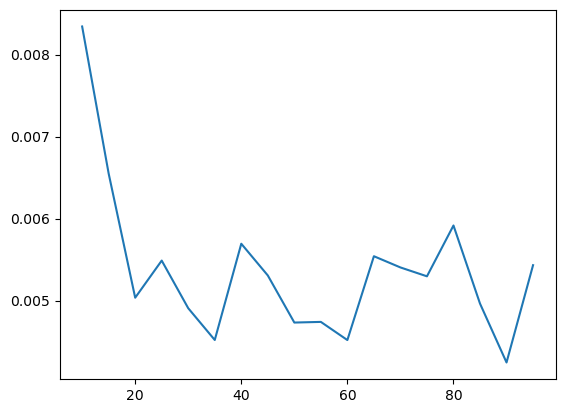

In [3]:
xplot = np.arange(10, 100, 5)
yplot = [cross_validation_loglikelihood(m, failed_rsample, kfolds=10) for m in xplot]
    
import matplotlib.pyplot as plt

plt.plot(xplot, yplot)